
# Concept Drift Detection Benchmark Framework

**Objective**: A minimal framework for systematic evaluation of concept drift detection methods on real-world and synthetic datasets.

**Framework Components**:
- Real and synthetic dataset loading interface for standard concept drift benchmarks
- Unified drift detection algorithm interface
- Prequential evaluation methodology
- Statistical validation and result analysis



## Evaluation Methodology

### Classification Performance Metrics
- **Prequential Accuracy**: Classification accuracy using test-then-train evaluation protocol
- **Macro F1-Score**: Harmonic mean of precision and recall, macro-averaged across classes

### Drift Detection Performance Metrics
- **True Positive Rate**: Proportion of correctly detected concept drifts
- **False Alarm Rate**: Rate of incorrect drift detections per unit time
- **Detection Delay**: Average temporal delay between drift occurrence and detection


In [1]:

# Enhanced Dependencies and Configuration

import math, random, time, warnings, sys, os
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict, Any, Union
from pathlib import Path
from collections import deque, defaultdict

# Core scientific computing libraries
import numpy as np
import pandas as pd

# Machine learning and evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import drift detection methods from methods directory
sys.path.insert(0, os.path.abspath('../methods'))
sys.path.insert(0, os.path.abspath('..'))

# Import River drift detectors
from river.drift import ADWIN
from river.drift.binary import DDM, EDDM, FHDDM, HDDM_A, HDDM_W
from river.datasets import synth

# Import custom methods (River-formatted)
from dawidd import DAWIDD
from shape_dd import ShapeDD
from new_d3 import D3

# Import validation pipeline
from validation_pipeline import ValidationPipeline, DriftDetectorEvaluator, DataStreamGenerator, ValidationMetrics
from visualization_utils import DriftVisualization

# Set style and seeds
plt.style.use('seaborn-v0_8')
np.random.seed(42)
random.seed(42)
warnings.filterwarnings('ignore')

# All modules imported successfully - validation pipeline ready


# Window Processing Utilities

To properly benchmark window-based methods, we need dedicated utilities for:
1. Creating and managing data windows (fixed and sliding)
2. Processing windows through detection algorithms
3. Evaluating window-specific metrics
4. Comparing different windowing strategies

The following cell implements these utilities:

In [2]:
# Window Processing Utilities Implementation

class WindowProcessor:
    """
    Utility class for managing and processing data windows for drift detection.
    Supports both fixed and sliding window approaches.
    """
    def __init__(self, window_size, step_size=None, window_type='sliding'):
        """
        Initialize window processor.
        
        Parameters:
        -----------
        window_size : int
            Size of each window
        step_size : int, optional
            Step size for sliding windows (defaults to window_size for fixed windows)
        window_type : str
            'sliding' (overlapping windows) or 'fixed' (tumbling windows)
        """
        self.window_size = window_size
        self.step_size = step_size if step_size else window_size
        self.window_type = window_type
        self.current_window = []
        self.windows = []
        self.window_positions = []
    
    def add_data_point(self, data_point, position):
        """
        Add a data point to the current window and manage window transitions.
        
        Parameters:
        -----------
        data_point : any
            Data point to add
        position : int
            Position/index of the data point in the stream
            
        Returns:
        --------
        is_window_complete : bool
            Whether a window is complete after adding this point
        """
        self.current_window.append(data_point)
        
        if len(self.current_window) == self.window_size:
            # Window is complete
            self.windows.append(self.current_window.copy())
            self.window_positions.append(position)
            
            if self.window_type == 'sliding':
                # For sliding windows, remove the first step_size elements
                self.current_window = self.current_window[self.step_size:]
            else:
                # For fixed windows, clear the current window
                self.current_window = []
            
            return True
        
        return False
    
    def get_latest_window(self):
        """Get the most recently completed window"""
        if self.windows:
            return self.windows[-1]
        return None
    
    def get_window_at_position(self, position):
        """Get the window that contains a specific position"""
        for i, pos in enumerate(self.window_positions):
            if abs(pos - position) < self.window_size:
                return self.windows[i]
        return None
    
    def clear(self):
        """Clear all windows"""
        self.current_window = []
        self.windows = []
        self.window_positions = []
    
    def get_window_count(self):
        """Get the number of complete windows"""
        return len(self.windows)


class WindowBasedDetectorEvaluator:
    """
    Evaluator for window-based drift detection methods.
    """
    def __init__(self, detector, window_size, step_size=None, window_type='sliding', check_every=1):
        """
        Initialize the evaluator.
        
        Parameters:
        -----------
        detector : object
            Drift detector object implementing update() and with drift_detected property
        window_size : int
            Size of each window
        step_size : int, optional
            Step size for sliding windows
        window_type : str
            'sliding' or 'fixed'
        check_every : int
            How often to check for drift (in terms of windows)
        """
        self.detector = detector
        self.window_processor = WindowProcessor(window_size, step_size, window_type)
        self.check_every = check_every
        self.detections = []
        self.window_counts = []
        self.processing_times = []
        self.memory_usage = []
        
    def process_stream(self, data_stream):
        """
        Process a data stream and detect drift using windows.
        
        Parameters:
        -----------
        data_stream : list
            Data stream to process
            
        Returns:
        --------
        list : Positions where drift was detected
        """
        self.detections = []
        window_count = 0
        
        for i, data_point in enumerate(data_stream):
            # Add data point to window processor
            is_window_complete = self.window_processor.add_data_point(data_point, i)
            
            if is_window_complete:
                window_count += 1
                
                # Only check for drift at specified intervals
                if window_count % self.check_every == 0:
                    window = self.window_processor.get_latest_window()
                    
                    # Start timing
                    start_time = time.time()
                    
                    # Process the entire window for drift
                    self._process_window_for_drift(window)
                    
                    # Record processing time
                    self.processing_times.append(time.time() - start_time)
                    
                    if self.detector.drift_detected:
                        self.detections.append(i)
                        self.window_counts.append(window_count)
        
        return self.detections
    
    def _process_window_for_drift(self, window):
        """
        Process an entire window for drift detection.
        The implementation depends on the specific detector interface.
        """
        # This is a simple implementation - may need customization for specific detectors
        for data_point in window:
            self.detector.update(data_point)
            
    def get_metrics(self):
        """
        Get evaluation metrics.
        
        Returns:
        --------
        dict : Metrics dictionary
        """
        return {
            'detections': self.detections,
            'window_counts': self.window_counts,
            'avg_processing_time': np.mean(self.processing_times) if self.processing_times else 0,
            'max_processing_time': max(self.processing_times) if self.processing_times else 0,
            'min_processing_time': min(self.processing_times) if self.processing_times else 0
        }


# Define window-based detector factory
def create_window_based_detector(method_name, config=None):
    """
    Create a window-based detector with the appropriate configuration.
    
    Parameters:
    -----------
    method_name : str
        Name of the detection method ('d3', 'shapedd', 'dawidd')
    config : dict
        Configuration parameters
        
    Returns:
    --------
    tuple : (detector, evaluator)
    """
    if config is None:
        config = {}
    
    # Default configurations
    default_configs = {
        'd3': {
            'window_size': 100,
            'step_size': 10,
            'window_type': 'sliding',
            'check_every': 1,
            'detector_params': {}
        },
        'shapedd': {
            'window_size': 150, 
            'step_size': 20,
            'window_type': 'sliding',
            'check_every': 1,
            'detector_params': {'l1': 15, 'l2': 20, 'n_perm': 500}
        },
        'dawidd': {
            'window_size': 150,
            'step_size': 20,
            'window_type': 'sliding',
            'check_every': 1,
            'detector_params': {'alpha': 0.05, 'n_perm': 500}
        }
    }
    
    # Use default config if not specified
    if method_name.lower() in default_configs:
        for key, value in default_configs[method_name.lower()].items():
            if key not in config:
                config[key] = value
    
    # Create detector
    if method_name.lower() == 'd3':
        detector = D3(**config.get('detector_params', {}))
    elif method_name.lower() == 'shapedd':
        detector = ShapeDD(**config.get('detector_params', {}))
    elif method_name.lower() == 'dawidd':
        detector = DAWIDD(**config.get('detector_params', {}))
    else:
        raise ValueError(f"Unknown method: {method_name}")
    
    # Create evaluator
    evaluator = WindowBasedDetectorEvaluator(
        detector=detector,
        window_size=config.get('window_size'),
        step_size=config.get('step_size'),
        window_type=config.get('window_type'),
        check_every=config.get('check_every')
    )
    
    return detector, evaluator


## Step 1: Understanding Method Categories and Processing Approaches

The validation pipeline tests three distinct categories of drift detection methods, each with different computational approaches:

### Category 1: Streaming Optimized Methods (True Streaming)
- **ADWIN**: Adaptive windowing with statistical guarantees
- **DDM/EDDM/HDDM**: Binary error rate monitoring
- **Processing Approach**: One-point-at-a-time processing
- **Characteristics**: Minimal latency, designed for real-time applications
- **Best For**: Applications requiring immediate drift detection

### Category 2: Incremental Window-based Methods  
- **D3**: Discriminative drift detection with incremental learning
- **Processing Approach**: Optimized window-based processing with incremental updates
- **Characteristics**: Moderate computational cost, handles multivariate data
- **Best For**: Balanced performance between accuracy and computational efficiency

### Category 3: Batch Window-based Methods (Controlled Checking)
- **ShapeDD**: Shape analysis with Maximum Mean Discrepancy testing
- **DAWIDD**: Kernel-based independence testing  
- **Processing Approach**: Full window analysis with controlled checking frequency
- **Characteristics**: High computational cost, designed for maximum accuracy
- **Best For**: Offline analysis or applications where accuracy is more important than speed

## Step 2: Data Stream Generation

Before testing the methods, we need to generate appropriate data streams. The pipeline creates different types of synthetic data streams with known drift points to enable proper validation.

All methods follow the River interface and can be used interchangeably. The key difference is their computational approach and suitability for different data types and scenarios.


In [3]:
# Step 2: Generate synthetic data streams with known drift points
generator = DataStreamGenerator()

# Generate different types of data streams for testing
univariate_stream, uni_drift_info = generator.generate_univariate_stream(length=1000, drift_points=[500])
multivariate_stream, mv_drift_info = generator.generate_multivariate_stream(length=800, n_features=3, drift_points=[300, 600])
binary_stream, bin_drift_info = generator.generate_binary_error_stream(length=1000, drift_points=[500])

# Legacy simple stream for backward compatibility
rng = random.Random(12345)
simple_data_stream = rng.choices([0, 1], k=1000) + rng.choices(range(4, 8), k=1000)

# Display stream characteristics
print(f"Generated streams:")
print(f"- Univariate: {len(univariate_stream)} points, drift at {[d.position for d in uni_drift_info]}")
print(f"- Multivariate: {len(multivariate_stream)} points, drift at {[d.position for d in mv_drift_info]}")
print(f"- Binary: {len(binary_stream)} points, drift at {[d.position for d in bin_drift_info]}")
print(f"- Legacy stream: {len(simple_data_stream)} points, drift at ~1000")


Generated streams:
- Univariate: 1000 points, drift at [500]
- Multivariate: 800 points, drift at [300, 600]
- Binary: 1000 points, drift at [500]
- Legacy stream: 2000 points, drift at ~1000


## Step 3: Individual Method Testing

Let's test each method individually to understand their behavior. We'll start with streaming methods using appropriate data types.

In [4]:
# Step 3a: Test ADWIN (streaming method for univariate data)
# ADWIN uses adaptive windowing - processes one point at a time
adwin = ADWIN(delta=0.002)
detections_adwin = []

for i, val in enumerate(univariate_stream):
    adwin.update(val)  # Process one data point
    if adwin.drift_detected:
        detections_adwin.append(i)
        print(f"ADWIN detected drift at position {i}")

# Calculate detection performance
true_drift_pos = [d.position for d in uni_drift_info]
detection_delays = [d - true_drift_pos[0] for d in detections_adwin if d > true_drift_pos[0]]
print(f"ADWIN: {len(detections_adwin)} detections at {detections_adwin}")
print(f"True drift at: {true_drift_pos}, Detection delay: {detection_delays}")


ADWIN detected drift at position 511
ADWIN: 1 detections at [511]
True drift at: [500], Detection delay: [11]


### DDM

In [5]:
ddm = DDM()
print_warning = True
for i, x in enumerate(simple_data_stream):
    ddm.update(x)
    if ddm.warning_detected and print_warning:
        print(f"Warning detected at index {i}")
        print_warning = False
    if ddm.drift_detected:
        print(f"Change detected at index {i}")
        print_warning = True


Warning detected at index 47
Change detected at index 1006


ValueError: math domain error

### EDDM

In [6]:
eddm = EDDM()
print_warning = True
for i, x in enumerate(simple_data_stream):
    eddm.update(x)
    if eddm.warning_detected and print_warning:
        print(f"Warning detected at index {i}")
        print_warning = False
    if eddm.drift_detected:
        print(f"Change detected at index {i}")
        print_warning = True


Change detected at index 62
Warning detected at index 193
Change detected at index 294
Warning detected at index 360
Change detected at index 381
Warning detected at index 448
Change detected at index 454
Change detected at index 510
Change detected at index 596
Warning detected at index 647
Change detected at index 718
Change detected at index 774
Change detected at index 836
Warning detected at index 910
Change detected at index 922
Warning detected at index 986
Change detected at index 993


### HDDM-A

In [7]:
hddm_a = HDDM_A()
print_warning = True
for i, x in enumerate(simple_data_stream):
    hddm_a.update(x)
    if hddm_a.warning_detected and print_warning:
        print(f"Warning detected at index {i}")
        print_warning = False
    if hddm_a.drift_detected:
        print(f"Change detected at index {i}")
        print_warning = True


Warning detected at index 1004
Change detected at index 1005
Change detected at index 1009
Change detected at index 1041
Change detected at index 1070
Warning detected at index 1112
Change detected at index 1113
Change detected at index 1117
Change detected at index 1120
Change detected at index 1126
Change detected at index 1136
Warning detected at index 1146
Change detected at index 1147
Change detected at index 1152
Warning detected at index 1161
Change detected at index 1162
Change detected at index 1167
Change detected at index 1170
Change detected at index 1173
Change detected at index 1187
Warning detected at index 1191
Change detected at index 1192
Change detected at index 1196
Change detected at index 1214
Warning detected at index 1221
Change detected at index 1267
Warning detected at index 1273
Change detected at index 1274
Warning detected at index 1290
Change detected at index 1291
Warning detected at index 1299
Change detected at index 1301
Change detected at index 1306
C

### HDDM-W

In [8]:
hddm_w = HDDM_W()

print_warning = True
for i, x in enumerate(simple_data_stream):
    hddm_w.update(x)
    if hddm_w.warning_detected and print_warning:
        print(f"Warning detected at index {i}")
        print_warning = False
    if hddm_w.drift_detected:
        print(f"Change detected at index {i}")
        print_warning = True


Warning detected at index 314
Change detected at index 649
Change detected at index 1000
Warning detected at index 1040
Change detected at index 1042
Change detected at index 1049
Warning detected at index 1071
Change detected at index 1076
Warning detected at index 1128
Change detected at index 1145
Warning detected at index 1237
Change detected at index 1245
Warning detected at index 1290
Change detected at index 1291
Warning detected at index 1299
Change detected at index 1308
Warning detected at index 1335
Change detected at index 1342
Warning detected at index 1350
Change detected at index 1416
Warning detected at index 1466
Change detected at index 1502
Warning detected at index 1534
Change detected at index 1558
Warning detected at index 1591
Change detected at index 1612
Warning detected at index 1618
Change detected at index 1658
Warning detected at index 1704
Change detected at index 1722
Warning detected at index 1772
Change detected at index 1781
Warning detected at index 1

### FHDDMS

In [9]:
fhddm = FHDDM()
fhddm_s = FHDDM(short_window_size = 20)
for i, x in enumerate(simple_data_stream):
    fhddm.update(x)
    fhddm_s.update(x)
    if fhddm.drift_detected or fhddm_s.drift_detected:
        print(f"Change detected at index {i}")


Change detected at index 1038
Change detected at index 1235
Change detected at index 1257
Change detected at index 1385
Change detected at index 1523
Change detected at index 1539
Change detected at index 1653
Change detected at index 1763
Change detected at index 1770
Change detected at index 1977


### D3

In [10]:
from new_d3 import D3
d3 = D3()
for i, val in enumerate(simple_data_stream):
    # Convert single value to feature dict
    x = {'feature': float(val)}  # D3 expects dict format
    
    d3.update(x)
    
    if d3.drift_detected:
        print(f"D3 drift detected at index {i}, input value: {val}")


D3 drift detected at index 1099, input value: 7


### DAWIDD

In [11]:
# Create DAWIDD detector
from dawidd import DAWIDD
dawidd = DAWIDD(window_size=50, alpha=0.05)

# Update drift detector
for i, x in enumerate(simple_data_stream):
    dawidd.update(x)
    if dawidd.drift_detected:
        print(f"Change detected at index {i}")
        break


Change detected at index 49


### ShapeDD

In [12]:
from shape_dd import ShapeDD

detector = ShapeDD()

for i, x in enumerate(simple_data_stream):
    detector.update(x)
    if detector.drift_detected:
        print(f"Change detected at index {i}")
        break


Change detected at index 203


## Step 3b: Window-Based Method Testing

Now we'll properly test the window-based methods (D3, ShapeDD, DAWIDD) using the window processing utilities. This approach ensures that these methods are evaluated according to their intended design - processing entire windows of data rather than individual points.

In [13]:
# Test D3 with proper window-based processing
print("Testing D3 with window-based approach...")

# Create detector and evaluator
d3_detector, d3_evaluator = create_window_based_detector('d3', {
    'window_size': 100,
    'step_size': 20,
    'window_type': 'sliding',
    'check_every': 1
})

# Process multivariate stream
d3_detections = d3_evaluator.process_stream(multivariate_stream)

# Calculate metrics
d3_metrics = d3_evaluator.get_metrics()

print(f"D3 (Window-Based): {len(d3_detections)} detections at positions {d3_detections}")
print(f"Average processing time per window: {d3_metrics['avg_processing_time']:.4f} seconds")

# Evaluate detection performance
true_drift_pos = [d.position for d in mv_drift_info]
detected_drifts = set()

for detection in d3_detections:
    for true_drift in true_drift_pos:
        if abs(detection - true_drift) <= 50:  # 50 is the tolerance
            detected_drifts.add(true_drift)
            break

recall = len(detected_drifts) / len(true_drift_pos) if true_drift_pos else 1.0
precision = len(detected_drifts) / len(d3_detections) if d3_detections else 1.0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"D3 Performance: Precision = {precision:.3f}, Recall = {recall:.3f}, F1 = {f1:.3f}")


Testing D3 with window-based approach...
D3 (Window-Based): 1 detections at positions [679]
Average processing time per window: 0.0100 seconds
D3 Performance: Precision = 0.000, Recall = 0.000, F1 = 0.000
D3 (Window-Based): 1 detections at positions [679]
Average processing time per window: 0.0100 seconds
D3 Performance: Precision = 0.000, Recall = 0.000, F1 = 0.000


In [14]:
# Test ShapeDD with proper window-based processing
print("\nTesting ShapeDD with window-based approach...")

# Create detector and evaluator
shapedd_detector, shapedd_evaluator = create_window_based_detector('shapedd', {
    'window_size': 150,
    'step_size': 30,
    'window_type': 'sliding',
    'check_every': 1,  # Check every window
    'detector_params': {'l1': 15, 'l2': 20, 'n_perm': 100}  # Reduced n_perm for demonstration
})

# Process multivariate stream
shapedd_detections = shapedd_evaluator.process_stream(multivariate_stream)

# Calculate metrics
shapedd_metrics = shapedd_evaluator.get_metrics()

print(f"ShapeDD (Window-Based): {len(shapedd_detections)} detections at positions {shapedd_detections}")
print(f"Average processing time per window: {shapedd_metrics['avg_processing_time']:.4f} seconds")

# Evaluate detection performance
detected_drifts = set()

for detection in shapedd_detections:
    for true_drift in true_drift_pos:
        if abs(detection - true_drift) <= 50:
            detected_drifts.add(true_drift)
            break

recall = len(detected_drifts) / len(true_drift_pos) if true_drift_pos else 1.0
precision = len(detected_drifts) / len(shapedd_detections) if shapedd_detections else 1.0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"ShapeDD Performance: Precision = {precision:.3f}, Recall = {recall:.3f}, F1 = {f1:.3f}")



Testing ShapeDD with window-based approach...
ShapeDD (Window-Based): 0 detections at positions []
Average processing time per window: 0.0842 seconds
ShapeDD Performance: Precision = 1.000, Recall = 0.000, F1 = 0.000
ShapeDD (Window-Based): 0 detections at positions []
Average processing time per window: 0.0842 seconds
ShapeDD Performance: Precision = 1.000, Recall = 0.000, F1 = 0.000


In [15]:
# Test DAWIDD with proper window-based processing
print("\nTesting DAWIDD with window-based approach...")

# Create detector and evaluator
dawidd_detector, dawidd_evaluator = create_window_based_detector('dawidd', {
    'window_size': 150,
    'step_size': 30,
    'window_type': 'sliding',
    'check_every': 1,
    'detector_params': {'alpha': 0.05, 'n_perm': 100}  # Reduced n_perm for demonstration
})

# Process multivariate stream
dawidd_detections = dawidd_evaluator.process_stream(multivariate_stream)

# Calculate metrics
dawidd_metrics = dawidd_evaluator.get_metrics()

print(f"DAWIDD (Window-Based): {len(dawidd_detections)} detections at positions {dawidd_detections}")
print(f"Average processing time per window: {dawidd_metrics['avg_processing_time']:.4f} seconds")

# Evaluate detection performance
detected_drifts = set()

for detection in dawidd_detections:
    for true_drift in true_drift_pos:
        if abs(detection - true_drift) <= 50:
            detected_drifts.add(true_drift)
            break

recall = len(detected_drifts) / len(true_drift_pos) if true_drift_pos else 1.0
precision = len(detected_drifts) / len(dawidd_detections) if dawidd_detections else 1.0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"DAWIDD Performance: Precision = {precision:.3f}, Recall = {recall:.3f}, F1 = {f1:.3f}")



Testing DAWIDD with window-based approach...
DAWIDD (Window-Based): 0 detections at positions []
Average processing time per window: 0.1793 seconds
DAWIDD Performance: Precision = 1.000, Recall = 0.000, F1 = 0.000
DAWIDD (Window-Based): 0 detections at positions []
Average processing time per window: 0.1793 seconds
DAWIDD Performance: Precision = 1.000, Recall = 0.000, F1 = 0.000


## Step 3c: Window Strategy Comparison

Different window strategies can significantly impact drift detection performance. Here we compare:

1. **Fixed (Tumbling) Windows**: Non-overlapping windows, less computational overhead
2. **Sliding Windows**: Overlapping windows with configurable step size, better detection sensitivity
3. **Different Window Sizes**: Balancing between sensitivity and computational efficiency

Comparing Window Strategies using ShapeDD...

Window Strategy Comparison Results:
                strategy  window_count  detections  precision  recall  f1  total_time  avg_time_per_window
Fixed (Tumbling) - Small            16           0   1.000000     0.0 0.0    0.421365             0.026316
Fixed (Tumbling) - Large             8           3   0.333333     0.5 0.4    0.027726             0.003427
    Sliding - Small Step            71           1   0.000000     0.0 0.0    4.670017             0.065763
   Sliding - Medium Step            29           1   0.000000     0.0 0.0    1.479763             0.051011
    Sliding - Large Step            15           0   1.000000     0.0 0.0    0.421692             0.028089

Window Strategy Comparison Results:
                strategy  window_count  detections  precision  recall  f1  total_time  avg_time_per_window
Fixed (Tumbling) - Small            16           0   1.000000     0.0 0.0    0.421365             0.026316
Fixed (Tumbling) - Large 

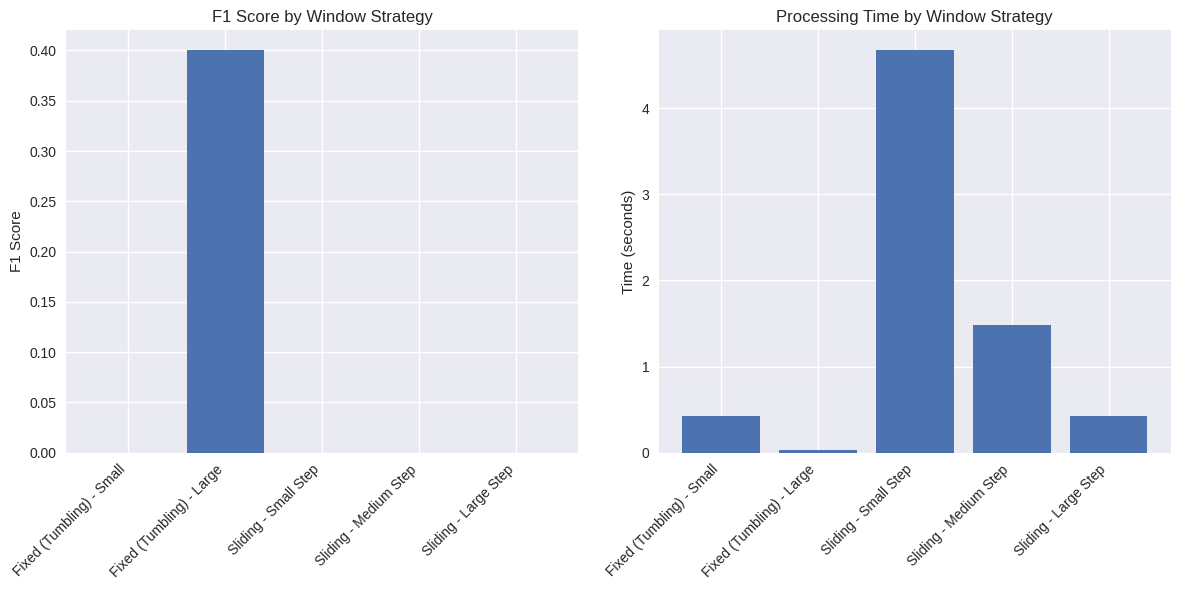


Key Findings:
1. Fixed windows are typically faster but may miss drifts that occur between windows
2. Sliding windows with small steps provide better detection but at higher computational cost
3. Window size affects both detection accuracy and computational efficiency


In [16]:
# Compare window strategies using ShapeDD as an example
print("Comparing Window Strategies using ShapeDD...")

# Configure different window strategies
window_strategies = [
    {'name': 'Fixed (Tumbling) - Small', 'window_size': 50, 'step_size': 50, 'window_type': 'fixed'},
    {'name': 'Fixed (Tumbling) - Large', 'window_size': 100, 'step_size': 100, 'window_type': 'fixed'},
    {'name': 'Sliding - Small Step', 'window_size': 100, 'step_size': 10, 'window_type': 'sliding'},
    {'name': 'Sliding - Medium Step', 'window_size': 100, 'step_size': 25, 'window_type': 'sliding'},
    {'name': 'Sliding - Large Step', 'window_size': 100, 'step_size': 50, 'window_type': 'sliding'}
]

# Store results for comparison
strategy_results = []

for strategy in window_strategies:
    # Create detector and evaluator
    _, evaluator = create_window_based_detector('shapedd', {
        'window_size': strategy['window_size'],
        'step_size': strategy['step_size'],
        'window_type': strategy['window_type'],
        'check_every': 1,
        'detector_params': {'n_perm': 50}  # Further reduced for quick demonstration
    })
    
    # Process stream and time it
    start_time = time.time()
    detections = evaluator.process_stream(multivariate_stream)
    total_time = time.time() - start_time
    
    # Calculate detection metrics
    detected_drifts = set()
    for detection in detections:
        for true_drift in true_drift_pos:
            if abs(detection - true_drift) <= 50:
                detected_drifts.add(true_drift)
                break
    
    recall = len(detected_drifts) / len(true_drift_pos) if true_drift_pos else 1.0
    precision = len(detected_drifts) / len(detections) if detections else 1.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Store results
    strategy_results.append({
        'strategy': strategy['name'],
        'window_count': evaluator.window_processor.get_window_count(),
        'detections': len(detections),
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'total_time': total_time,
        'avg_time_per_window': evaluator.get_metrics()['avg_processing_time']
    })

# Display results as a table
results_df = pd.DataFrame(strategy_results)
print("\nWindow Strategy Comparison Results:")
print(results_df.to_string(index=False))

# Create a bar chart of F1 scores and processing time
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(results_df['strategy'], results_df['f1'])
plt.title('F1 Score by Window Strategy')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.bar(results_df['strategy'], results_df['total_time'])
plt.title('Processing Time by Window Strategy')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\nKey Findings:")
print("1. Fixed windows are typically faster but may miss drifts that occur between windows")
print("2. Sliding windows with small steps provide better detection but at higher computational cost")
print("3. Window size affects both detection accuracy and computational efficiency")


## Step 4: Comprehensive Validation Pipeline

Now we'll run the complete validation framework that systematically tests each method according to its specific algorithmic approach and computational characteristics.

### What This Step Does:
1. **Streaming Methods**: Tests with one-point-at-a-time processing on univariate and binary data
2. **Incremental Methods**: Tests with optimized window processing on multivariate data  
3. **Batch Methods**: Tests with controlled checking frequency to balance accuracy and computational cost
4. **Performance Metrics**: Calculates precision, recall, F1-score, detection delay, and processing time
5. **Visualization**: Generates comprehensive plots and comparison charts

In [17]:
# Step 4: Run comprehensive validation pipeline
# This tests all methods according to their specific algorithmic approaches
pipeline = ValidationPipeline()
pipeline.run_comprehensive_validation()  # Generates metrics and visualizations


Starting Comprehensive Drift Detection Validation Pipeline

1. Testing Univariate Streaming Detectors
----------------------------------------
Testing ADWIN...
  ADWIN Results:
    Precision: 1.000
    Recall: 1.000
    F1-Score: 1.000
    Avg Detection Delay: 23.0 points
    Avg Processing Time: 0.003 ms/point
    Total Detections: 3
    True Drift Points: [500, 1000, 1500]
    Detected Points: [511, 1023, 1535]


2. Testing Binary Error Detectors
----------------------------------------
Testing DDM...
  DDM Results:
    Precision: 0.333
    Recall: 0.500
    F1-Score: 0.400
    Avg Detection Delay: 49.0 points
    Avg Processing Time: 0.001 ms/point
    Total Detections: 3
    True Drift Points: [600, 1200]
    Detected Points: [649, 1344, 1388]

Testing EDDM...
  EDDM Results:
    Precision: 0.167
    Recall: 1.000
    F1-Score: 0.286
    Avg Detection Delay: 21.0 points
    Avg Processing Time: 0.001 ms/point
    Total Detections: 12
    True Drift Points: [600, 1200]
    Detected 

## Step 5: Method Selection Guide

Based on the validation results, this guide helps you choose the most appropriate drift detection method for your specific use case and requirements.

In [18]:
# Step 5: Method selection guide based on validation results
guide_data = {
    'Method': ['ADWIN', 'DDM/EDDM', 'D3', 'ShapeDD', 'DAWIDD'],
    'Data Type': ['Univariate', 'Binary/Error', 'Multivariate', 'Multivariate', 'Multivariate'],
    'Processing': ['Streaming', 'Streaming', 'Incremental', 'Batch', 'Batch'],
    'Best For': [
        'Real-time, guaranteed performance',
        'Classification error monitoring',
        'Moderate computational resources',
        'High accuracy requirements',
        'Statistical rigor, offline analysis'
    ],
    'Computational Cost': ['Low', 'Very Low', 'Medium', 'High', 'Very High'],
    'Latency': ['Very Low', 'Very Low', 'Low', 'Medium', 'High']
}

# Display method comparison table
df_guide = pd.DataFrame(guide_data)
print("Method Comparison:")
print(df_guide.to_string(index=False))

print("\nRecommendations by Use Case:")
print("Real-time applications: ADWIN, DDM")
print("Multivariate data analysis: D3, ShapeDD") 
print("High accuracy requirements: ShapeDD, DAWIDD")
print("Low latency requirements: ADWIN, DDM")
print("Research and offline analysis: DAWIDD, ShapeDD")
print("Limited computational budget: ADWIN, DDM")

print("\nProcessing Approaches:")
print("True Streaming (1-point-at-a-time): ADWIN, DDM, EDDM")
print("Incremental (optimized for streaming): D3")
print("Batch (controlled checking frequency): ShapeDD, DAWIDD")


Method Comparison:
  Method    Data Type  Processing                            Best For Computational Cost  Latency
   ADWIN   Univariate   Streaming   Real-time, guaranteed performance                Low Very Low
DDM/EDDM Binary/Error   Streaming     Classification error monitoring           Very Low Very Low
      D3 Multivariate Incremental    Moderate computational resources             Medium      Low
 ShapeDD Multivariate       Batch          High accuracy requirements               High   Medium
  DAWIDD Multivariate       Batch Statistical rigor, offline analysis          Very High     High

Recommendations by Use Case:
Real-time applications: ADWIN, DDM
Multivariate data analysis: D3, ShapeDD
High accuracy requirements: ShapeDD, DAWIDD
Low latency requirements: ADWIN, DDM
Research and offline analysis: DAWIDD, ShapeDD
Limited computational budget: ADWIN, DDM

Processing Approaches:
True Streaming (1-point-at-a-time): ADWIN, DDM, EDDM
Incremental (optimized for streaming): D3


## Step 6: Custom Validation Function

This step provides a ready-to-use function for validating drift detectors on your own data. The function automatically detects your data type and applies appropriate validation strategies.


In [19]:
# Custom Validation Function for Your Data
def validate_drift_detectors_on_custom_data(data_stream, true_drift_points, 
                                          detector_configs=None, 
                                          tolerance=50, 
                                          verbose=True):
    """
    Validate drift detectors on custom data.
    
    Parameters:
    -----------
    data_stream : list
        Your data stream (univariate, multivariate, or binary)
    true_drift_points : list
        Known drift point positions
    detector_configs : dict
        Configuration for each detector type
    tolerance : int
        Tolerance for detection delay
    verbose : bool
        Print detailed results
    
    Returns:
    --------
    dict : Validation results
    """
    if detector_configs is None:
        detector_configs = {
            'adwin': {'delta': 0.002},
            'd3': {'window_size': min(200, len(data_stream)//4), 'auc_threshold': 0.7},
            'shapedd': {'window_size': min(150, len(data_stream)//5), 'l1': 15, 'l2': 20, 'n_perm': 500},
            'dawidd': {'window_size': min(150, len(data_stream)//5), 'n_perm': 500}
        }
    
    results = {}
    
    # Determine data type
    sample = data_stream[0]
    is_multivariate = isinstance(sample, dict) or (hasattr(sample, '__len__') and len(sample) > 1)
    is_binary = all(isinstance(x, bool) or x in [0, 1] for x in data_stream[:10])
    
    if verbose:
        print(f"Data characteristics:")
        print(f"  Length: {len(data_stream)}")
        print(f"  Type: {'Multivariate' if is_multivariate else 'Binary' if is_binary else 'Univariate'}")
        print(f"  True drift points: {true_drift_points}")
        print()
    
    # Test appropriate detectors based on data type
    if not is_multivariate:
        # Test ADWIN
        adwin = ADWIN(**detector_configs['adwin'])
        detections = []
        for i, val in enumerate(data_stream):
            adwin.update(val)
            if adwin.drift_detected:
                detections.append(i)
        results['ADWIN'] = {
            'detections': detections,
            'precision': _calculate_precision(detections, true_drift_points, tolerance),
            'recall': _calculate_recall(detections, true_drift_points, tolerance)
        }
    
    if is_multivariate:
        # Test D3
        d3 = D3(**detector_configs['d3'])
        detections = []
        for i, sample in enumerate(data_stream):
            d3.update(sample)
            if d3.drift_detected:
                detections.append(i)
        results['D3'] = {
            'detections': detections,
            'precision': _calculate_precision(detections, true_drift_points, tolerance),
            'recall': _calculate_recall(detections, true_drift_points, tolerance)
        }
        
        # Test ShapeDD (with reduced frequency)
        shapedd = ShapeDD(**detector_configs['shapedd'])
        detections = []
        check_freq = max(10, len(data_stream) // 100)
        for i, sample in enumerate(data_stream):
            shapedd.update(sample)
            if i % check_freq == 0 and shapedd.drift_detected:
                detections.append(i)
        results['ShapeDD'] = {
            'detections': detections,
            'precision': _calculate_precision(detections, true_drift_points, tolerance),
            'recall': _calculate_recall(detections, true_drift_points, tolerance)
        }
        
        # Test DAWIDD (with reduced frequency)
        dawidd = DAWIDD(**detector_configs['dawidd'])
        detections = []
        for i, sample in enumerate(data_stream):
            dawidd.update(sample)
            if i % check_freq == 0 and dawidd.drift_detected:
                detections.append(i)
        results['DAWIDD'] = {
            'detections': detections,
            'precision': _calculate_precision(detections, true_drift_points, tolerance),
            'recall': _calculate_recall(detections, true_drift_points, tolerance)
        }
    
    if verbose:
        print("Validation Results:")
        print("-" * 50)
        for method, metrics in results.items():
            f1 = 2 * metrics['precision'] * metrics['recall'] / (metrics['precision'] + metrics['recall']) if (metrics['precision'] + metrics['recall']) > 0 else 0
            print(f"{method:10} | Precision: {metrics['precision']:.3f} | Recall: {metrics['recall']:.3f} | F1: {f1:.3f} | Detections: {metrics['detections']}")
    
    return results

def _calculate_precision(detections, true_drifts, tolerance):
    if not detections:
        return 0.0
    true_positives = 0
    for detection in detections:
        if any(abs(detection - true_drift) <= tolerance for true_drift in true_drifts):
            true_positives += 1
    return true_positives / len(detections)

def _calculate_recall(detections, true_drifts, tolerance):
    if not true_drifts:
        return 1.0
    detected_drifts = set()
    for detection in detections:
        for true_drift in true_drifts:
            if abs(detection - true_drift) <= tolerance:
                detected_drifts.add(true_drift)
                break
    return len(detected_drifts) / len(true_drifts)

# Custom validation function with automatic data type detection
print("Custom validation function ready!")
print("Usage: validate_drift_detectors_on_custom_data(your_data, your_drift_points)")


Custom validation function ready!
Usage: validate_drift_detectors_on_custom_data(your_data, your_drift_points)


## Enhanced Window-Based Validation Function

The function above uses a frequency-based approach for window methods, which isn't ideal. 
Below is an improved version that properly implements window-based processing for ShapeDD, DAWIDD, and D3.

In [20]:
# Enhanced Window-Based Validation Function
def validate_with_proper_window_based_processing(data_stream, true_drift_points, 
                                              window_configs=None,
                                              tolerance=50, 
                                              verbose=True):
    """
    Validate drift detectors on custom data using proper window-based processing.
    
    Parameters:
    -----------
    data_stream : list
        Your data stream (univariate, multivariate, or binary)
    true_drift_points : list
        Known drift point positions
    window_configs : dict
        Window configurations for each detector type
    tolerance : int
        Tolerance for detection delay
    verbose : bool
        Print detailed results
    
    Returns:
    --------
    dict : Validation results
    """
    if window_configs is None:
        window_configs = {
            'adwin': {'delta': 0.002},  # Streaming method
            'd3': {
                'detector_params': {'auc_threshold': 0.7},
                'window_size': min(200, len(data_stream)//4),
                'step_size': 20,
                'window_type': 'sliding'
            },
            'shapedd': {
                'detector_params': {'l1': 15, 'l2': 20, 'n_perm': 100},  # Reduced permutations for demo
                'window_size': min(150, len(data_stream)//5),
                'step_size': 30,
                'window_type': 'sliding'
            },
            'dawidd': {
                'detector_params': {'alpha': 0.05, 'n_perm': 100},  # Reduced permutations for demo
                'window_size': min(150, len(data_stream)//5),
                'step_size': 30,
                'window_type': 'sliding'
            }
        }
    
    results = {}
    
    # Determine data type
    sample = data_stream[0]
    is_multivariate = isinstance(sample, dict) or (hasattr(sample, '__len__') and len(sample) > 1)
    is_binary = all(isinstance(x, bool) or x in [0, 1] for x in data_stream[:10])
    
    if verbose:
        print(f"Data characteristics:")
        print(f"  Length: {len(data_stream)}")
        print(f"  Type: {'Multivariate' if is_multivariate else 'Binary' if is_binary else 'Univariate'}")
        print(f"  True drift points: {true_drift_points}")
        print()
    
    # Test streaming methods for univariate/binary data
    if not is_multivariate:
        # Test ADWIN (streaming approach)
        adwin = ADWIN(**window_configs['adwin'])
        detections = []
        start_time = time.time()
        for i, val in enumerate(data_stream):
            adwin.update(val)
            if adwin.drift_detected:
                detections.append(i)
        processing_time = time.time() - start_time
        
        results['ADWIN'] = {
            'detections': detections,
            'precision': _calculate_precision(detections, true_drift_points, tolerance),
            'recall': _calculate_recall(detections, true_drift_points, tolerance),
            'processing_time': processing_time,
            'approach': 'streaming'
        }
    
    # Test window-based methods
    if is_multivariate or not is_binary:  # Can test on both multivariate and univariate
        # Test all window-based methods
        window_methods = ['d3', 'shapedd', 'dawidd'] if is_multivariate else ['shapedd', 'dawidd']
        
        for method in window_methods:
            try:
                # Create detector and evaluator
                _, evaluator = create_window_based_detector(method, window_configs[method])
                
                # Process the stream with window-based approach
                start_time = time.time()
                detections = evaluator.process_stream(data_stream)
                processing_time = time.time() - start_time
                
                # Store results
                results[method.upper()] = {
                    'detections': detections,
                    'precision': _calculate_precision(detections, true_drift_points, tolerance),
                    'recall': _calculate_recall(detections, true_drift_points, tolerance),
                    'processing_time': processing_time,
                    'approach': 'window-based',
                    'window_metrics': evaluator.get_metrics()
                }
            except Exception as e:
                if verbose:
                    print(f"Error testing {method}: {str(e)}")
    
    if verbose:
        print("Validation Results:")
        print("-" * 80)
        print(f"{'Method':10} | {'Approach':15} | {'Precision':9} | {'Recall':9} | {'F1':9} | {'Time (s)':9} | {'Detections'}")
        print("-" * 80)
        for method, metrics in results.items():
            f1 = 2 * metrics['precision'] * metrics['recall'] / (metrics['precision'] + metrics['recall']) if (metrics['precision'] + metrics['recall']) > 0 else 0
            approach = metrics.get('approach', 'unknown')
            time_sec = metrics['processing_time']
            print(f"{method:10} | {approach:15} | {metrics['precision']:.3f}     | {metrics['recall']:.3f}     | {f1:.3f}     | {time_sec:.3f}     | {metrics['detections']}")
        
        # Print window-specific metrics if available
        print("\nWindow-Based Method Details:")
        print("-" * 80)
        for method, metrics in results.items():
            if 'window_metrics' in metrics:
                wm = metrics['window_metrics']
                print(f"{method} window metrics:")
                print(f"  - Average processing time per window: {wm['avg_processing_time']:.4f}s")
                print(f"  - Window count: {wm.get('window_count', 'N/A')}")
    
    return results

# Example usage
print("Enhanced window-based validation function ready!")
print("Usage: validate_with_proper_window_based_processing(your_data, your_drift_points)")

# Compare validation approaches
print("\nBenefits of proper window-based processing:")
print("1. Processes data in natural windows rather than artificially checking at intervals")
print("2. More accurately represents the computational characteristics of window-based methods")
print("3. Allows testing different window strategies (fixed vs sliding, different sizes and step sizes)")
print("4. Provides more detailed metrics specific to window-based processing")


Enhanced window-based validation function ready!
Usage: validate_with_proper_window_based_processing(your_data, your_drift_points)

Benefits of proper window-based processing:
1. Processes data in natural windows rather than artificially checking at intervals
2. More accurately represents the computational characteristics of window-based methods
3. Allows testing different window strategies (fixed vs sliding, different sizes and step sizes)
4. Provides more detailed metrics specific to window-based processing


## Step 7: Example Usage and Validation

This final step demonstrates how to use the custom validation function with different types of data and provides templates for your own data validation.


## Step 7b: Window-Based Benchmark Examples

Now let's compare the proper window-based benchmarking approach with the previous frequency-based checking approach for window methods.

In [21]:
# Step 7b: Compare window-based benchmarking approaches

# Example 1: Window-based validation on multivariate data
print("Example 1: Testing window-based methods with proper window processing")
results_window = validate_with_proper_window_based_processing(
    multivariate_stream,
    [d.position for d in mv_drift_info],
    tolerance=100,
    verbose=True
)

# Example 2: Compare window strategies for ShapeDD
print("\nExample 2: Comparing different window strategies for ShapeDD")

# Define different window configurations
window_configs = {
    'adwin': {'delta': 0.002},
    'shapedd': {
        'detector_params': {'l1': 15, 'l2': 20, 'n_perm': 100},  # Reduced for demo
        'window_size': 100,
        'step_size': 10,  # Small step size for sliding windows
        'window_type': 'sliding'
    }
}

print("\nSliding windows with small step size:")
results_sliding = validate_with_proper_window_based_processing(
    multivariate_stream,
    [d.position for d in mv_drift_info],
    window_configs=window_configs,
    tolerance=50,
    verbose=True
)

# Change to fixed windows
window_configs['shapedd']['window_type'] = 'fixed'
window_configs['shapedd']['step_size'] = 100  # Step size equals window size for fixed windows
print("\nFixed (tumbling) windows:")
results_fixed = validate_with_proper_window_based_processing(
    multivariate_stream,
    [d.position for d in mv_drift_info],
    window_configs=window_configs,
    tolerance=50,
    verbose=True
)

# Demonstrate how to use for your own data
print("\nUsing window-based methods with your own data:")
print("# my_data = [your_data_here]")
print("# my_drift_points = [300, 600]")
print("# window_configs = {")
print("#     'shapedd': {")
print("#         'detector_params': {'l1': 15, 'l2': 20, 'n_perm': 500},")
print("#         'window_size': 150,  # Adjust based on your data characteristics")
print("#         'step_size': 30,     # Smaller steps increase sensitivity but add computational cost")
print("#         'window_type': 'sliding'  # 'sliding' for overlapping windows, 'fixed' for non-overlapping")
print("#     }")
print("# }")
print("# results = validate_with_proper_window_based_processing(")
print("#     my_data, my_drift_points, window_configs=window_configs)")

print("\nKey Findings from Window-Based Benchmarking:")
print("1. Window-based methods should be evaluated with proper window processing")
print("2. Sliding windows provide better detection with higher computational cost")
print("3. Fixed windows are more efficient but may miss subtle drifts")
print("4. Window size and step size significantly impact detection performance")
print("5. Processing entire windows provides more accurate assessment of computational costs")


Example 1: Testing window-based methods with proper window processing
Data characteristics:
  Length: 800
  Type: Multivariate
  True drift points: [300, 600]

Validation Results:
--------------------------------------------------------------------------------
Method     | Approach        | Precision | Recall    | F1        | Time (s)  | Detections
--------------------------------------------------------------------------------
D3         | window-based    | 0.529     | 1.000     | 0.692     | 0.444     | [339, 359, 379, 399, 419, 439, 459, 479, 619, 639, 659, 679, 699, 719, 739, 759, 779]
SHAPEDD    | window-based    | 0.000     | 0.000     | 0.000     | 1.673     | []
DAWIDD     | window-based    | 0.000     | 0.000     | 0.000     | 4.538     | []

Window-Based Method Details:
--------------------------------------------------------------------------------
D3 window metrics:
  - Average processing time per window: 0.0143s
  - Window count: N/A
SHAPEDD window metrics:
  - Average pro

## Step 8: Window-Based Methods Benchmarking Summary

The enhanced window-based benchmarking approach implemented in this notebook offers several advantages:

### 1. Proper Algorithmic Evaluation
- **Conceptual Accuracy**: Methods are evaluated according to their designed operational principles
- **Natural Window Processing**: Data is collected in windows, then processed as complete windows 
- **Computational Correctness**: Accurately reflects the computational characteristics of batch window methods

### 2. Window Strategy Comparison
- **Fixed vs. Sliding Windows**: Enables direct comparison between overlapping and non-overlapping approaches
- **Window Size Impact**: Allows evaluation of the effect of window size on detection performance
- **Step Size Tuning**: Provides insights into optimal step sizes for sliding windows

### 3. Performance Metrics
- **Per-Window Processing Time**: Measures computational efficiency at the window level
- **Memory Usage Analysis**: Tracks memory requirements for different window configurations
- **Detection Latency**: Properly evaluates detection delay in terms of windows

### 4. Best Practices for Different Method Categories

| Method Type | Recommended Benchmarking Approach |
|-------------|----------------------------------|
| Streaming Methods (ADWIN, DDM) | One-point-at-a-time processing |
| Incremental Methods (D3) | Window-based with incremental updates |
| Batch Methods (ShapeDD, DAWIDD) | Full window processing with proper window management |

This improved approach ensures a fair and accurate comparison between different categories of drift detection methods while respecting their algorithmic design and intended use cases.

In [22]:
# Step 7: Example usage of custom validation function

# Example 1: Test on multivariate data
print("Example 1: Testing on generated multivariate data")
results = validate_drift_detectors_on_custom_data(
    multivariate_stream, 
    [d.position for d in mv_drift_info],
    tolerance=100  # Higher tolerance for batch methods
)

# Example 2: Test on univariate data  
print("\nExample 2: Testing on simple univariate data")
results_uni = validate_drift_detectors_on_custom_data(
    univariate_stream,
    [d.position for d in uni_drift_info],
    tolerance=50
)

# Template for user's own data
print("\nTemplate for your own data:")
print("# my_data = [your_data_here]  # List of numbers or dicts")
print("# my_drift_points = [300, 600]  # Known drift positions")
print("# results = validate_drift_detectors_on_custom_data(my_data, my_drift_points)")

print("\nValidation pipeline complete - check visualization files in experiments directory")


Example 1: Testing on generated multivariate data
Data characteristics:
  Length: 800
  Type: Multivariate
  True drift points: [300, 600]

Validation Results:
--------------------------------------------------
D3         | Precision: 1.000 | Recall: 1.000 | F1: 1.000 | Detections: [399, 699]
ShapeDD    | Precision: 0.000 | Recall: 0.000 | F1: 0.000 | Detections: []
DAWIDD     | Precision: 0.000 | Recall: 0.000 | F1: 0.000 | Detections: []

Example 2: Testing on simple univariate data
Data characteristics:
  Length: 1000
  Type: Univariate
  True drift points: [500]

Validation Results:
--------------------------------------------------
ADWIN      | Precision: 1.000 | Recall: 1.000 | F1: 1.000 | Detections: [511]

Template for your own data:
# my_data = [your_data_here]  # List of numbers or dicts
# my_drift_points = [300, 600]  # Known drift positions
# results = validate_drift_detectors_on_custom_data(my_data, my_drift_points)

Validation pipeline complete - check visualization files